In [40]:
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import itertools
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
plt.style.use('ggplot')

In [2]:
#importing all files
nyc = pd.read_csv('vaccine-data/nyc.csv')
houston = pd.read_csv('vaccine-data/Houston.csv')
la = pd.read_csv('vaccine-data/la.csv')
chicago = pd.read_csv('vaccine-data/chicago.csv')

## Data Cleaning

In [3]:
#starting with new york
nyc['city'] = 'new york' #adding location column
nyc['date'] = pd.to_datetime(nyc['DATE']) #converting dates to datetime

In [4]:
new_nyc = nyc[nyc['date'] >= '2021-01-01'] #filtering to consistent timeframe
new_nyc['total_doses'] = new_nyc['ADMIN_ALLDOSES_DAILY'] #getting consistent column name for vaccines administered

In [5]:
print(new_nyc['date'].nunique()) #checking to make sure same number of days included
print(len(new_nyc))

166
166


In [6]:
#houston
houston['date'] = pd.to_datetime(houston['Date_str'])
new_houston = houston[(houston['date'] >= '2021-01-01') & (houston['date'] <= '2021-06-15')]
new_houston['total_doses'] = new_houston['Vaccinated']

In [7]:
new_houston = new_houston.groupby(['date'], as_index=False).sum()
new_houston['city'] = 'houston'

In [8]:
new_houston['total_doses'] = new_houston['total_doses'].diff()

In [9]:
#chicago
chicago['city'] = 'chicago'
chicago['date'] = pd.to_datetime(chicago['Date'])
chicago['total_doses'] = chicago['Total Doses - Daily']
new_chicago = chicago[chicago['date'] >= '2021-01-01']

In [10]:
new_chicago['date'].nunique()

166

In [11]:
la['date'] = pd.to_datetime(la['Date (Dose 1)'])
new_la = la[la['date'] >= '2021-01-01']

In [12]:
new_la = new_la.groupby(['date'], as_index=False).sum()
new_la.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 166 entries, 0 to 165
Data columns (total 5 columns):
date                  166 non-null datetime64[ns]
Dose1_all             166 non-null float64
Population (16+)      166 non-null float64
Population (12-17)    166 non-null float64
Population (65+)      166 non-null float64
dtypes: datetime64[ns](1), float64(4)
memory usage: 7.8 KB


In [13]:
new_la['total_doses'] = new_la['Dose1_all']
new_la['city'] = 'los angeles'

### Merging dataframes

In [14]:
def to_merge(dataframe):
    city_subset = dataframe[['date', 'city', 'total_doses']]
    return(city_subset)

In [15]:
nyc_merge = to_merge(new_nyc)
houston_merge  = to_merge(new_houston)
chicago_merge  = to_merge(new_chicago)
la_merge  = to_merge(new_la)

In [16]:
combined = pd.concat([nyc_merge, houston_merge, chicago_merge, la_merge],
                     ignore_index=True, sort=False).sort_values(by='date')

time_indexed_combined = combined.set_index('date')

time_indexed_combined.head()

,city,total_doses
date,,
2021-01-01,new york,167.0
2021-01-01,houston,NaN
2021-01-01,los angeles,1112.0
2021-01-01,chicago,48.0
2021-01-02,houston,2737.0


In [17]:
ti_mean = time_indexed_combined.groupby('date').mean()
ti_mean.head()

,total_doses
date,
2021-01-01,442.333333
2021-01-02,3071.250000
2021-01-03,1693.250000
2021-01-04,8262.500000
2021-01-05,9231.000000


In [18]:
# #resampling by month
# ti_monthly = time_indexed_combined.resample("MS")

# ti_monthly_mean = ti_monthly.mean()

# ti_monthly_mean.head(10)

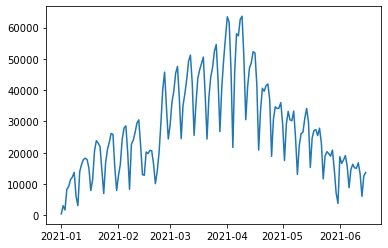

In [19]:
plt.plot(ti_mean)

In [20]:
nyc_ts = nyc_merge.set_index('date')['total_doses']
hou_ts = houston_merge.set_index('date')['total_doses']
chi_ts = chicago_merge.set_index('date')['total_doses']
la_ts = la_merge.set_index('date')['total_doses']

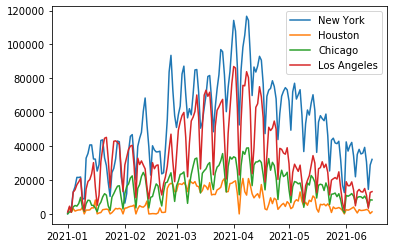

In [21]:
plt.plot(nyc_ts, label='New York')
plt.plot(hou_ts, label='Houston')
plt.plot(chi_ts, label='Chicago')
plt.plot(la_ts, label='Los Angeles')
plt.legend()


## Checking for Trends

In [63]:
def plot_roll_stats(data, city):
    roll_mean = data.rolling(window=7).mean()
    roll_std = data.rolling(window=7, center=False).std()
    fig = plt.figure(figsize=(11,7))
    plt.plot(data, color='blue',label='Original')
    plt.plot(roll_mean, color='red', label='Rolling Mean')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation of {}'.format(city))
    plt.show(block=False)

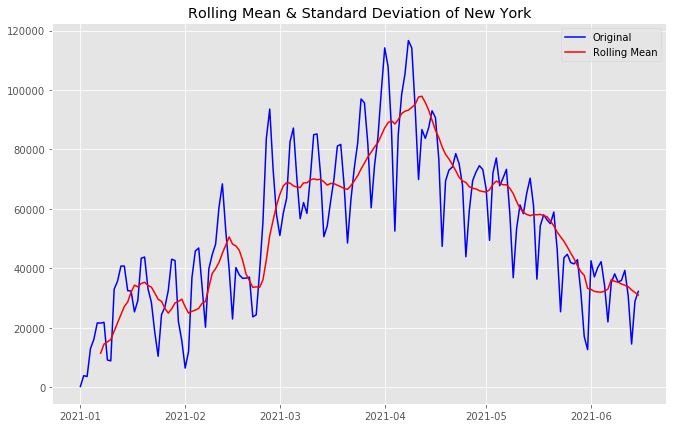

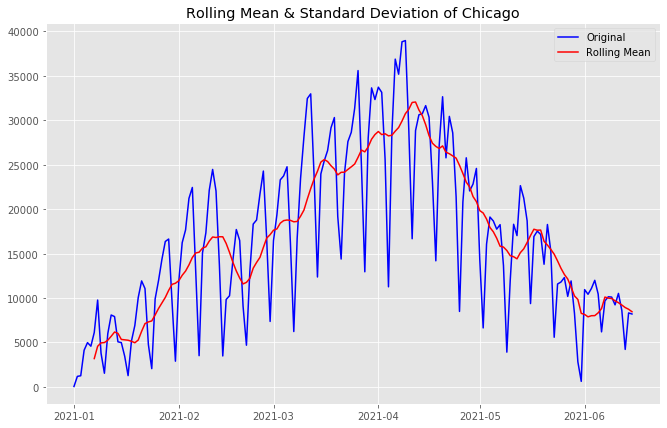

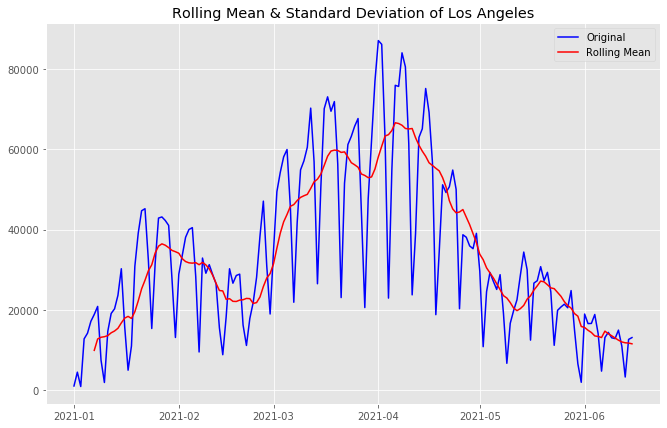

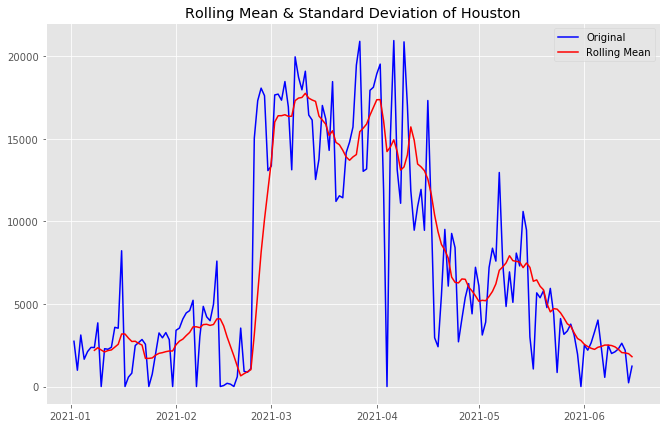

In [64]:
plot_roll_stats(nyc_ts, 'New York')
plot_roll_stats(chi_ts, 'Chicago')
plot_roll_stats(la_ts, 'Los Angeles')
plot_roll_stats(hou_ts, 'Houston')

In [72]:
from statsmodels.tsa.stattools import adfuller

def d_f_test(data):
    dftest = adfuller(data)

    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
#     print ('Results of Dickey-Fuller test: \n')

    print(dfoutput)

In [83]:
test = d_f_test(la_ts)

Test Statistic                  -1.547956
p-value                          0.509669
#Lags Used                       8.000000
Number of Observations Used    157.000000
Critical Value (1%)             -3.472703
Critical Value (5%)             -2.880132
Critical Value (10%)            -2.576683
dtype: float64


 If the test statistic is less than the critical value, we reject the null hypothesis and say that the series is stationary. Results uphold the null hypothesis: the time series is not stationary.

In [24]:
# # Subtract the moving average from the original data to see if it is stationary
# data_minus_roll_mean = data - roll_mean
# data_minus_roll_mean.head(15)
# data_minus_roll_mean.dropna(inplace=True)

In [25]:
# fig = plt.figure(figsize=(11,7))
# plt.plot(data_minus_roll_mean, color='blue',label='Sales - rolling mean')
# plt.legend(loc='best')
# plt.title('Sales while the rolling mean is subtracted')
# plt.show(block=False)

In [ ]:
## Removing trends

In [ ]:
# log transform
# subtract rolling mean
#differencing

## Time Series Modeling

In [28]:
import statsmodels
import itertools

In [31]:
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
pdqs = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]


In [44]:
# Run a grid with pdq and seasonal pdq parameters calculated above and get the best AIC value
ans = []
for comb in pdq:
    for combs in pdqs:
        try:
            mod = sm.tsa.statespace.SARIMAX(nyc_ts,
                                            order=comb,
                                            seasonal_order=combs,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            output = mod.fit()
            ans.append([comb, combs, output.aic])
            print('ARIMA {} x {}12 : AIC Calculated ={}'.format(comb, combs, output.aic))
        except:
            continue

C:\Users\christina.sarver\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\christina.sarver\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA (0, 0, 0) x (0, 0, 0, 12)12 : AIC Calculated =4095.0097331103093


C:\Users\christina.sarver\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\christina.sarver\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA (0, 0, 0) x (0, 0, 1, 12)12 : AIC Calculated =3731.6700502795375
ARIMA (0, 0, 0) x (0, 1, 0, 12)12 : AIC Calculated =3525.406369988149


C:\Users\christina.sarver\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\christina.sarver\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\christina.sarver\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\christina.sarver\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA (0, 0, 0) x (0, 1, 1, 12)12 : AIC Calculated =3244.407497232748
ARIMA (0, 0, 0) x (1, 0, 0, 12)12 : AIC Calculated =3546.702960004158


C:\Users\christina.sarver\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\christina.sarver\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\christina.sarver\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\christina.sarver\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA (0, 0, 0) x (1, 0, 1, 12)12 : AIC Calculated =3518.56575217012


C:\Users\christina.sarver\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\christina.sarver\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA (0, 0, 0) x (1, 1, 0, 12)12 : AIC Calculated =3267.680140011702


C:\Users\christina.sarver\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\christina.sarver\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA (0, 0, 0) x (1, 1, 1, 12)12 : AIC Calculated =3246.3147035847055
ARIMA (0, 0, 1) x (0, 0, 0, 12)12 : AIC Calculated =3953.3831209261953


C:\Users\christina.sarver\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\christina.sarver\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\christina.sarver\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\christina.sarver\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA (0, 0, 1) x (0, 0, 1, 12)12 : AIC Calculated =3642.9172877779492
ARIMA (0, 0, 1) x (0, 1, 0, 12)12 : AIC Calculated =3393.8154336992784

C:\Users\christina.sarver\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\christina.sarver\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


C:\Users\christina.sarver\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\christina.sarver\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA (0, 0, 1) x (0, 1, 1, 12)12 : AIC Calculated =3120.8017390162922


C:\Users\christina.sarver\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\christina.sarver\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA (0, 0, 1) x (1, 0, 0, 12)12 : AIC Calculated =3678.2510579070445


C:\Users\christina.sarver\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\christina.sarver\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA (0, 0, 1) x (1, 0, 1, 12)12 : AIC Calculated =3631.7377641460707


C:\Users\christina.sarver\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\christina.sarver\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA (0, 0, 1) x (1, 1, 0, 12)12 : AIC Calculated =3166.345098541415


C:\Users\christina.sarver\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\christina.sarver\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA (0, 0, 1) x (1, 1, 1, 12)12 : AIC Calculated =3122.8008695925764
ARIMA (0, 1, 0) x (0, 0, 0, 12)12 : AIC Calculated =3561.207022394986
ARIMA (0, 1, 0) x (0, 0, 1, 12)12 : AIC Calculated =3292.3664976117598
ARIMA (0, 1, 0) x (0, 1, 0, 12)12 : AIC Calculated =3445.4371689867803

C:\Users\christina.sarver\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\christina.sarver\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\christina.sarver\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\christina.sarver\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\christina.sarver\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: 

C:\Users\christina.sarver\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\christina.sarver\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA (0, 1, 0) x (0, 1, 1, 12)12 : AIC Calculated =3094.5928807750242
ARIMA (0, 1, 0) x (1, 0, 0, 12)12 : AIC Calculated =3320.4074173093213


C:\Users\christina.sarver\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\christina.sarver\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\christina.sarver\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\christina.sarver\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA (0, 1, 0) x (1, 0, 1, 12)12 : AIC Calculated =3290.9429980670175
ARIMA (0, 1, 0) x (1, 1, 0, 12)12 : AIC Calculated =3166.6677444971697


C:\Users\christina.sarver\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\christina.sarver\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\christina.sarver\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\christina.sarver\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA (0, 1, 0) x (1, 1, 1, 12)12 : AIC Calculated =3080.1696366225287
ARIMA (0, 1, 1) x (0, 0, 0, 12)12 : AIC Calculated =3537.5465789344576


C:\Users\christina.sarver\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\christina.sarver\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\christina.sarver\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\christina.sarver\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA (0, 1, 1) x (0, 0, 1, 12)12 : AIC Calculated =3271.078144079544
ARIMA (0, 1, 1) x (0, 1, 0, 12)12 : AIC Calculated =3412.006743129259


C:\Users\christina.sarver\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\christina.sarver\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\christina.sarver\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\christina.sarver\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA (0, 1, 1) x (0, 1, 1, 12)12 : AIC Calculated =3070.695675229087
ARIMA (0, 1, 1) x (1, 0, 0, 12)12 : AIC Calculated =3319.7191852785472


C:\Users\christina.sarver\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\christina.sarver\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\christina.sarver\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\christina.sarver\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA (0, 1, 1) x (1, 0, 1, 12)12 : AIC Calculated =3271.1311702333405
ARIMA (0, 1, 1) x (1, 1, 0, 12)12 : AIC Calculated =3161.1747254017737

C:\Users\christina.sarver\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\christina.sarver\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


C:\Users\christina.sarver\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\christina.sarver\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA (0, 1, 1) x (1, 1, 1, 12)12 : AIC Calculated =3070.454271665136
ARIMA (1, 0, 0) x (0, 0, 0, 12)12 : AIC Calculated =3582.2741069890717


C:\Users\christina.sarver\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\christina.sarver\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\christina.sarver\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\christina.sarver\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA (1, 0, 0) x (0, 0, 1, 12)12 : AIC Calculated =3312.6259630679724
ARIMA (1, 0, 0) x (0, 1, 0, 12)12 : AIC Calculated =3438.8410492798457


C:\Users\christina.sarver\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\christina.sarver\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\christina.sarver\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\christina.sarver\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA (1, 0, 0) x (0, 1, 1, 12)12 : AIC Calculated =3101.818524552197


C:\Users\christina.sarver\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\christina.sarver\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA (1, 0, 0) x (1, 0, 0, 12)12 : AIC Calculated =3321.384977148619


C:\Users\christina.sarver\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\christina.sarver\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA (1, 0, 0) x (1, 0, 1, 12)12 : AIC Calculated =3312.763238331805
ARIMA (1, 0, 0) x (1, 1, 0, 12)12 : AIC Calculated =3150.3131417113273


C:\Users\christina.sarver\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\christina.sarver\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\christina.sarver\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\christina.sarver\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA (1, 0, 0) x (1, 1, 1, 12)12 : AIC Calculated =3100.481064406553
ARIMA (1, 0, 1) x (0, 0, 0, 12)12 : AIC Calculated =3557.612516431304


C:\Users\christina.sarver\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\christina.sarver\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\christina.sarver\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\christina.sarver\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA (1, 0, 1) x (0, 0, 1, 12)12 : AIC Calculated =3293.3172816040596
ARIMA (1, 0, 1) x (0, 1, 0, 12)12 : AIC Calculated =3383.872830443558


C:\Users\christina.sarver\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\christina.sarver\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\christina.sarver\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\christina.sarver\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA (1, 0, 1) x (0, 1, 1, 12)12 : AIC Calculated =3068.0634609976005
ARIMA (1, 0, 1) x (1, 0, 0, 12)12 : AIC Calculated =3320.1044149119793


C:\Users\christina.sarver\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\christina.sarver\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\christina.sarver\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\christina.sarver\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA (1, 0, 1) x (1, 0, 1, 12)12 : AIC Calculated =3293.4324921222087


C:\Users\christina.sarver\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\christina.sarver\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA (1, 0, 1) x (1, 1, 0, 12)12 : AIC Calculated =3126.4071369423873


C:\Users\christina.sarver\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\christina.sarver\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA (1, 0, 1) x (1, 1, 1, 12)12 : AIC Calculated =3066.9052362489806
ARIMA (1, 1, 0) x (0, 0, 0, 12)12 : AIC Calculated =3560.5901275024535
ARIMA (1, 1, 0) x (0, 0, 1, 12)12 : AIC Calculated =3292.0935854026493
ARIMA (1, 1, 0) x (0, 1, 0, 12)12 : AIC Calculated =3443.162341046068


C:\Users\christina.sarver\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\christina.sarver\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\christina.sarver\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\christina.sarver\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\christina.sarver\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: 

ARIMA (1, 1, 0) x (0, 1, 1, 12)12 : AIC Calculated =3092.559541300753
ARIMA (1, 1, 0) x (1, 0, 0, 12)12 : AIC Calculated =3299.8768877001044


C:\Users\christina.sarver\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\christina.sarver\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\christina.sarver\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\christina.sarver\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA (1, 1, 0) x (1, 0, 1, 12)12 : AIC Calculated =3292.124949474628
ARIMA (1, 1, 0) x (1, 1, 0, 12)12 : AIC Calculated =3143.559132094203


C:\Users\christina.sarver\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\christina.sarver\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\christina.sarver\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\christina.sarver\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA (1, 1, 0) x (1, 1, 1, 12)12 : AIC Calculated =3091.857491287873
ARIMA (1, 1, 1) x (0, 0, 0, 12)12 : AIC Calculated =3535.6774857118944


C:\Users\christina.sarver\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\christina.sarver\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\christina.sarver\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\christina.sarver\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA (1, 1, 1) x (0, 0, 1, 12)12 : AIC Calculated =3263.7129190921346
ARIMA (1, 1, 1) x (0, 1, 0, 12)12 : AIC Calculated =3404.9261981081377


C:\Users\christina.sarver\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\christina.sarver\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\christina.sarver\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\christina.sarver\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA (1, 1, 1) x (0, 1, 1, 12)12 : AIC Calculated =3071.6752229212184


C:\Users\christina.sarver\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\christina.sarver\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA (1, 1, 1) x (1, 0, 0, 12)12 : AIC Calculated =3299.2000077678513


C:\Users\christina.sarver\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\christina.sarver\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA (1, 1, 1) x (1, 0, 1, 12)12 : AIC Calculated =3271.70465075833


C:\Users\christina.sarver\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\christina.sarver\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA (1, 1, 1) x (1, 1, 0, 12)12 : AIC Calculated =3139.4869908856226


C:\Users\christina.sarver\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\christina.sarver\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA (1, 1, 1) x (1, 1, 1, 12)12 : AIC Calculated =3072.0709213748614


In [45]:
ans_df = pd.DataFrame(ans, columns=['pdq', 'pdqs', 'aic'])
ans_df.loc[ans_df['aic'].idxmin()]

pdq         (1, 0, 1)
pdqs    (1, 1, 1, 12)
aic           3066.91
Name: 47, dtype: object

In [46]:
# Plug the optimal parameter values into a new SARIMAX model
ARIMA_MODEL = sm.tsa.statespace.SARIMAX(nyc_ts, 
                                        order=(1, 1, 1), 
                                        seasonal_order=(1, 1, 1, 12), 
                                        enforce_stationarity=False, 
                                        enforce_invertibility=False)

# Fit the model and print results
output = ARIMA_MODEL.fit()

print(output.summary().tables[1])

C:\Users\christina.sarver\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\christina.sarver\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3626      1.459     -0.249      0.804      -3.222       2.497
ma.L1          0.5187      1.449      0.358      0.720      -2.321       3.359
ar.S.L12      -0.1873      0.341     -0.550      0.583      -0.855       0.481
ma.S.L12      -1.0451      0.101    -10.357      0.000      -1.243      -0.847
sigma2       3.95e+08   7.59e-09    5.2e+16      0.000    3.95e+08    3.95e+08


The first 3/5 features have p values > than 0.05 so we can't consider them significant

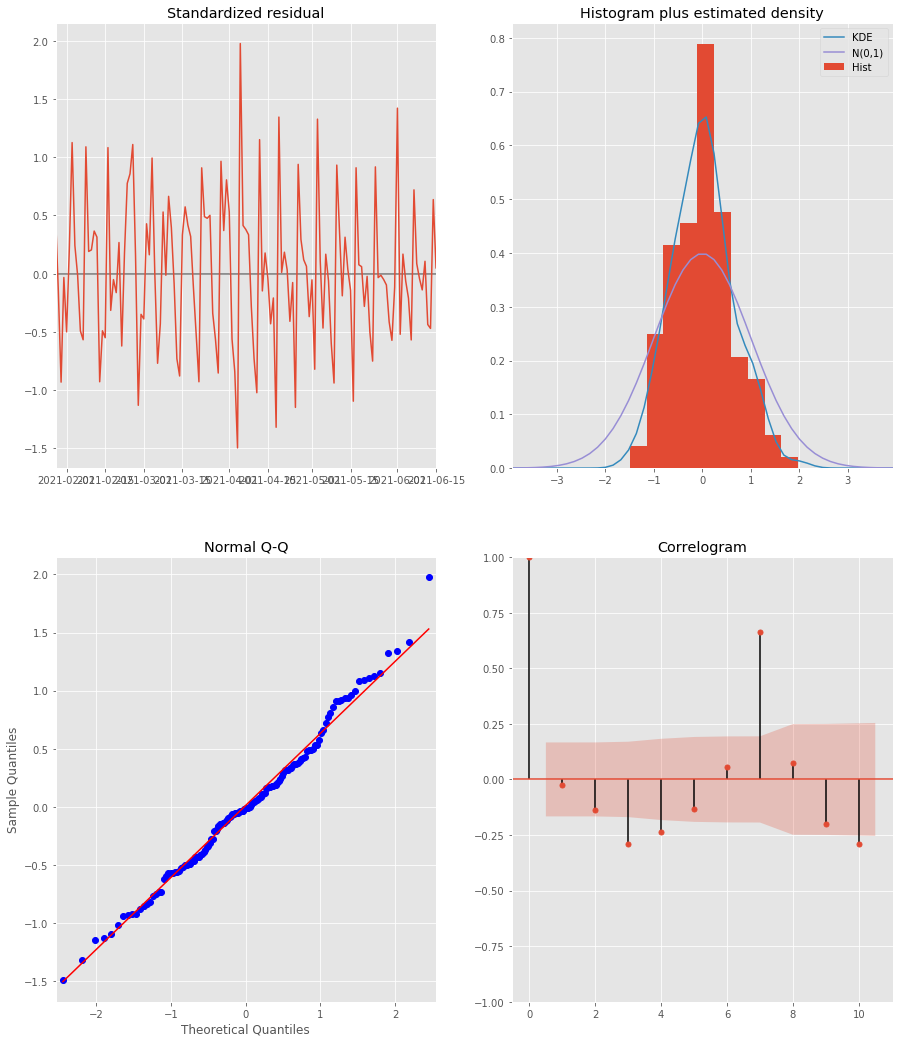

In [47]:
output.plot_diagnostics(figsize=(15, 18))
plt.show()

ex evaluation

In the top right plot, we see that the red KDE line follows closely with the N(0,1) line (where N(0,1)) is the standard notation for a normal distribution with mean 0 and standard deviation of 1). This is a good indication that the residuals are normally distributed.

The qq-plot on the bottom left shows that the ordered distribution of residuals (blue dots) follows the linear trend of the samples taken from a standard normal distribution with N(0, 1). Again, this is a strong indication that the residuals are normally distributed.

The residuals over time (top left plot) don't display any obvious seasonality and appear to be white noise. This is confirmed by the autocorrelation (i.e. correlogram) plot on the bottom right, which shows that the time series residuals have low correlation with lagged versions of itself.

In [ ]:
## validating the model

In [50]:
pred = output.get_prediction(start=pd.to_datetime('2021-01-01'), dynamic=False)
pred_conf = pred.conf_int()

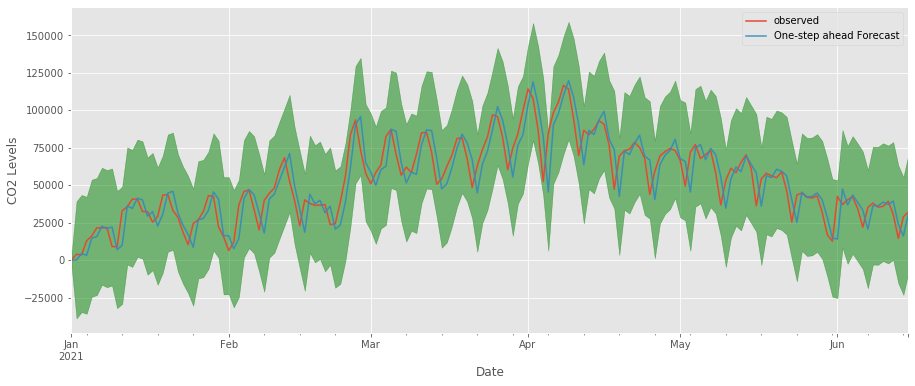

In [52]:
# Plot real vs predicted values along with confidence interval

rcParams['figure.figsize'] = 15, 6

# Plot observed values
ax = nyc_ts['2021':].plot(label='observed')

# Plot predicted values
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=0.9)

# Plot the range for confidence intervals
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='g', alpha=0.5)

# Set axes labels
ax.set_xlabel('Date')
ax.set_ylabel('CO2 Levels')
plt.legend()

plt.show()

In [53]:
# Get the real and predicted values
forecasted = pred.predicted_mean
true = nyc_ts['2021-01-01':]

# Compute the mean square error
mse = ((forecasted - true) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 139030825.34


In [54]:
pred_dynamic = output.get_prediction(start=pd.to_datetime('2021-01-01'), dynamic=True, full_results=True)
pred_dynamic_conf = pred_dynamic.conf_int()

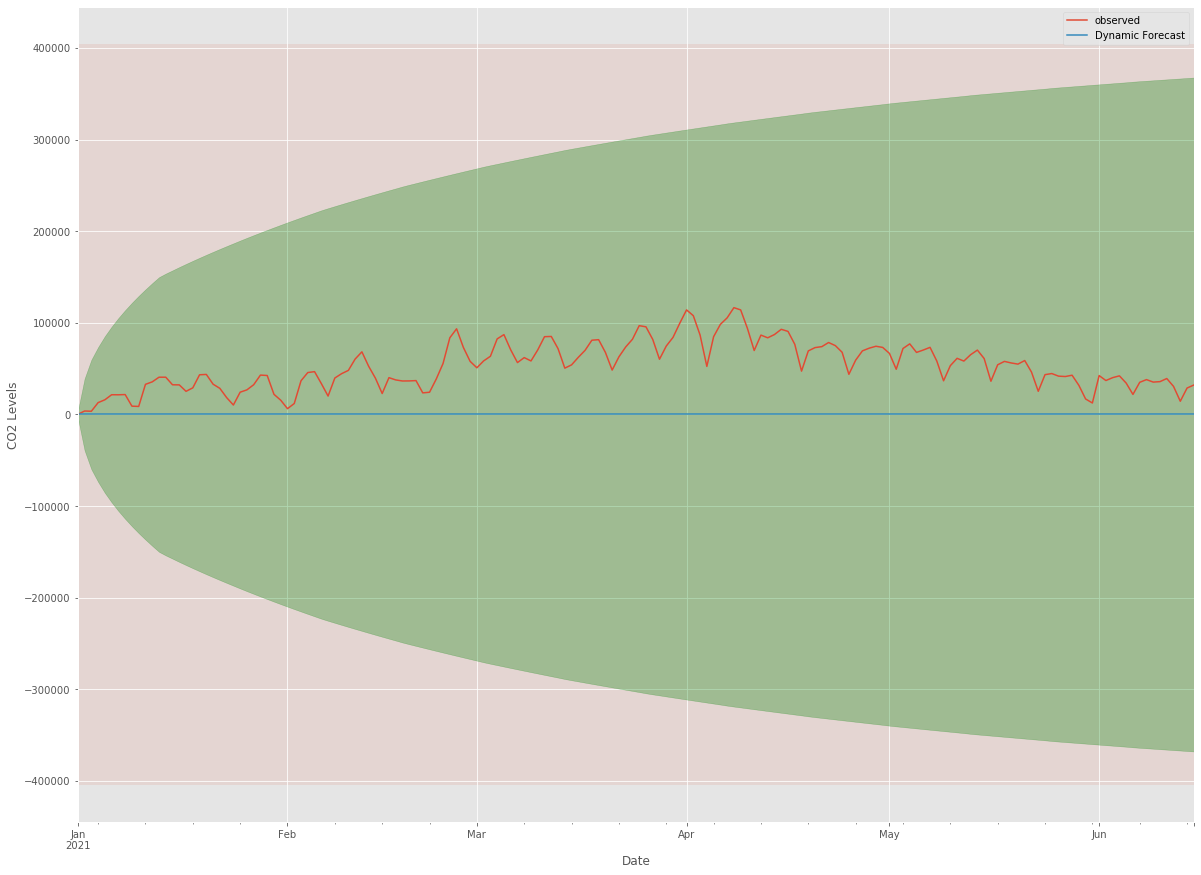

In [56]:
# Plot the dynamic forecast with confidence intervals.

ax = nyc_ts['2021':].plot(label='observed', figsize=(20, 15))
pred_dynamic.predicted_mean.plot(label='Dynamic Forecast', ax=ax)

ax.fill_between(pred_dynamic_conf.index,
                pred_dynamic_conf.iloc[:, 0],
                pred_dynamic_conf.iloc[:, 1], color='g', alpha=.3)

ax.fill_betweenx(ax.get_ylim(), pd.to_datetime('2021-01-01'), forecasted.index[-1], alpha=.1, zorder=-1)

ax.set_xlabel('Date')
ax.set_ylabel('CO2 Levels')

plt.legend()
plt.show()

In [58]:
# Get the real and predicted values
forecasted = pred_dynamic.predicted_mean
true = nyc_ts['2021-01-01':]

# Compute the mean square error
mse = ((forecasted - true) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 3451870072.4


In [61]:
# Get forecast 500 steps ahead in future
prediction = output.get_forecast(steps=100)

# Get confidence intervals of forecasts
pred_conf = prediction.conf_int()

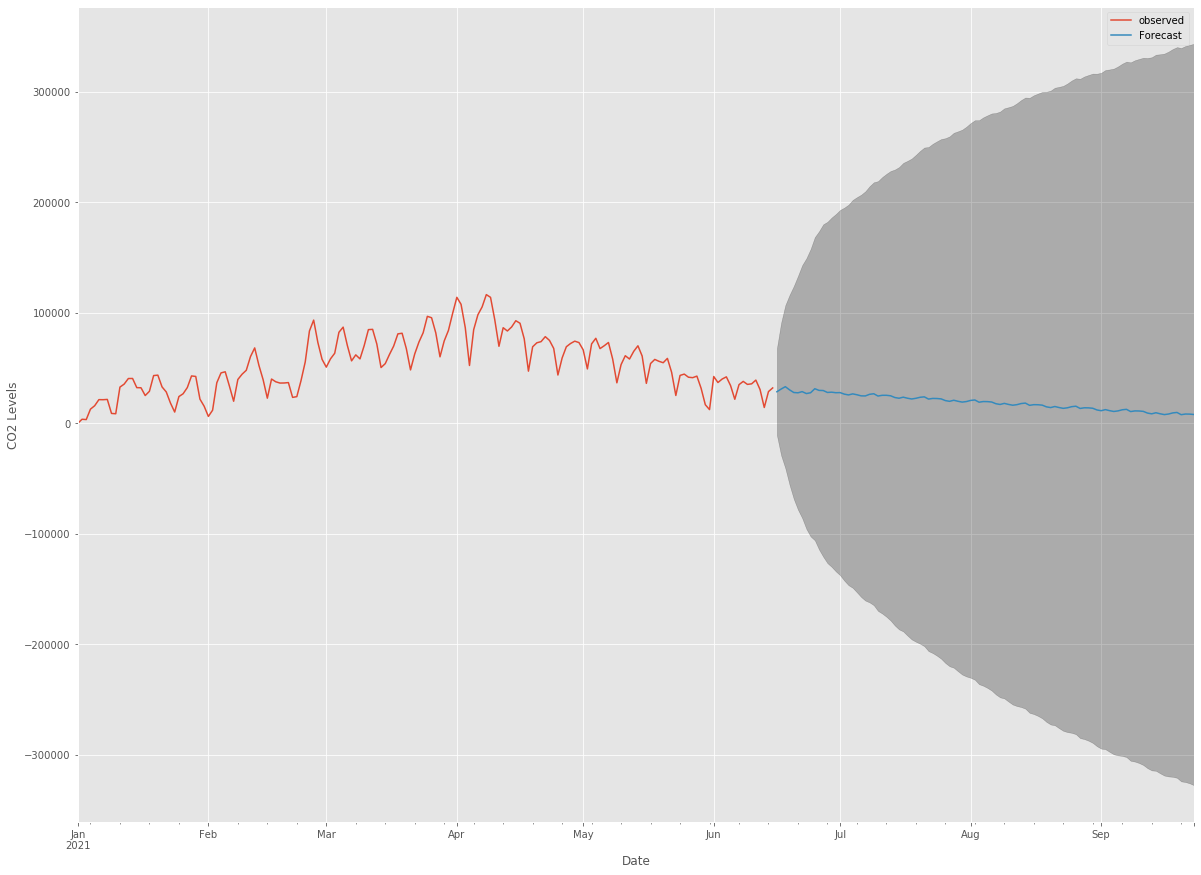

In [62]:
# Plot future predictions with confidence intervals
ax = nyc_ts.plot(label='observed', figsize=(20, 15))
prediction.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='k', alpha=0.25)
ax.set_xlabel('Date')
ax.set_ylabel('CO2 Levels')

plt.legend()
plt.show()